### Data source

The data source consists of files `BX-Users.csv`, `BX-Books.csv`, `BX-Book-Ratings.csv` (available here: http://www2.informatik.uni-freiburg.de/~cziegler/BX/).

### Datasets' description

- `BX-Users`
Contains the users. 
    - User IDs (***User-ID***) have been anonymized and map to integers. 
    - Demographic data is provided (***Location***, ***Age***) if available. Otherwise, these fields contain NULL-values.


- `BX-Books`
Books are identified by their respective ISBN. 
    - Invalid ISBNs have already been removed from the dataset. 
    - Some content-based information is given (***Book-Title***, ***Book-Author***, ***Year-Of-Publication***, ***Publisher***), obtained from Amazon Web Services. 
    - In case of several authors, only the first is provided. 
    - URLs linking to cover images are also given, appearing in three different flavours (***Image-URL-S***, ***Image-URL-M***, ***Image-URL-L***), i.e., small, medium, large. These URLs point to the Amazon web site.


- `BX-Book-Ratings`
Contains the book rating information. 
    - Ratings (***Book-Rating***) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

### Load datasets

In [2]:
books_df = pd.read_csv('BX-Books.csv', sep=';', on_bad_lines='skip', encoding='latin-1',
                       dtype={'Year-Of-Publication': 'str'})
users_df = pd.read_csv('BX-Users.csv', sep=';', on_bad_lines='skip', encoding='latin-1')
ratings_df = pd.read_csv('BX-Book-Ratings.csv', sep=';', on_bad_lines='skip', encoding='latin-1')

* To fix warning, I replaced the **error_bad_lines** argument with **on_bad_lines** argument in all three pd.read_csv functions. The **on_bad_lines='skip'** argument will skip the bad lines instead of throwing an error.
* Next warning message indicated that in the dataset `BX-Books.csv` there are mixed data types in column 3. I specified the data type for column 3 explicitly. I set column 3 (***Year-Of-Publication***) to be of type *str*, which will allow to retain the mixed data types in that column.

### Explore datasets

In [3]:
def separation():
    print('***************************************\n')
def describe_df(df, name):
    print('shape of ' + name + ': ' + str(df.shape) + '\n')
    separation()
    print('head of ' + name + ' dataset')
    display(df.head())
    separation()
    print('info of ' + name + ' dataset\n')
    display(df.info())
    separation()
    print('description of ' + name + ' dataset')
    display(df.describe())
    separation()
    print('number of unique values in ' + name + ' dataset')
    display(df.nunique())

In [4]:
describe_df(books_df, 'BX-Books.csv')

shape of BX-Books.csv: (271360, 8)

***************************************

head of BX-Books.csv dataset


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


***************************************

info of BX-Books.csv dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


None

***************************************

description of BX-Books.csv dataset


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,118,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,17627,7535,2,2,2


***************************************

number of unique values in BX-Books.csv dataset


ISBN                   271360
Book-Title             242135
Book-Author            102023
Year-Of-Publication       118
Publisher               16807
Image-URL-S            271044
Image-URL-M            271044
Image-URL-L            271041
dtype: int64

In [5]:
describe_df(users_df, 'BX-Users.csv')

shape of BX-Users.csv: (278858, 3)

***************************************

head of BX-Users.csv dataset


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


***************************************

info of BX-Users.csv dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


None

***************************************

description of BX-Users.csv dataset


,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


***************************************

number of unique values in BX-Users.csv dataset


User-ID     278858
Location     57339
Age            165
dtype: int64

In [6]:
describe_df(ratings_df, 'BX-Book-Ratings.csv')

shape of BX-Book-Ratings.csv: (1149780, 3)

***************************************

head of BX-Book-Ratings.csv dataset


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


***************************************

info of BX-Book-Ratings.csv dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


None

***************************************

description of BX-Book-Ratings.csv dataset


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


***************************************

number of unique values in BX-Book-Ratings.csv dataset


User-ID        105283
ISBN           340556
Book-Rating        11
dtype: int64

### Merge datasets
I'll merge three datasets into a single dataframe using pd.merge based on the common columns.
* Firstly I merge `ratings_df` with `books_df` on common column **ISBN**. 
* Then I merge resulting dataframe with `users_df` using column **User-ID**. 

In [7]:
data = pd.merge(ratings_df, books_df, on='ISBN')
data = pd.merge(data, users_df, on='User-ID')

In [8]:
display(data.head())

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,http://images.amazon.com/images/P/0812533550.0...,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,http://images.amazon.com/images/P/0679745580.0...,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,http://images.amazon.com/images/P/0060173289.0...,"cincinnati, ohio, usa",23.0


Reasons for merging datasets:


> Merging datasets into one can be useful when the data we want to analyze are stored in different sources but have some connection with each other. In this case, combining three datasets can help analyze data about books, users, and user ratings for books.
* **Supplementing information**: if one dataset has information that is not in the others, merging can help create a more complete database.
* **Reducing the number of datasets**: merging datasets can help reduce the number of files that need to be stored and processed.
* **Simplify analysis**: merging datasets can help simplify data analysis by allowing you to view data in context with each other.

### Data preprocessing

In [9]:
# Drop unnecessary columns
data.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

In [10]:
# Check for duplicates
print('Number of duplicates:', data.duplicated().sum())

Number of duplicates: 0


* Because there are no duplicates in the dataset, it is not necessary to use the function to remove duplicate rows.

In [11]:
# Check for missing values
print(data.isnull().sum())

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Location                    0
Age                    277835
dtype: int64


* Since a large number of rows lack information about age, I decided not to delete these rows and replace them with the median value of **Age** column.

In [12]:
# Fill missing values with median
data['Age'].fillna(data['Age'].median(), inplace=True)

In [13]:
# Remove rows with missing values
data.dropna(inplace=True)

In [14]:
display(data.dtypes)

User-ID                  int64
ISBN                    object
Book-Rating              int64
Book-Title              object
Book-Author             object
Year-Of-Publication     object
Publisher               object
Location                object
Age                    float64
dtype: object

All features with values of the string type are not continuous, but so called **categorical (discrete)**.
* I will replace all of them with numeric codes.
* I will convert them to numeric representation using `...cat.codes`.

In [15]:
obj_columns = data.select_dtypes('object').columns
data[obj_columns] = data[obj_columns].astype('category').apply(lambda x: x.cat.codes)

### Handle Outliers in Dataset

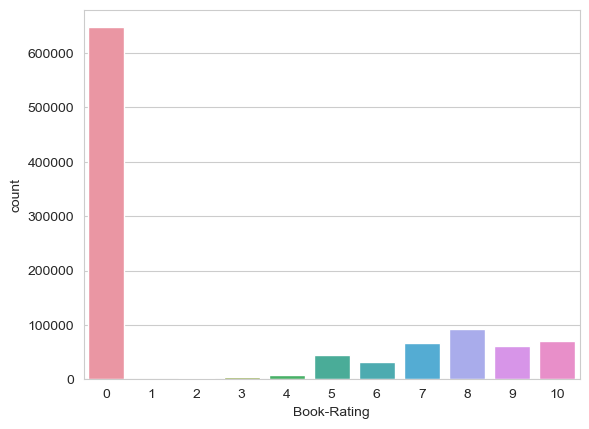

In [16]:
_ = sns.countplot(x='Book-Rating', data=data)

The number of grades of zero seems strange, in relation to the others, so I decided to replace the grades of zero with Nan.

In [17]:
data['Book-Rating'] = data['Book-Rating'].replace(0, None)

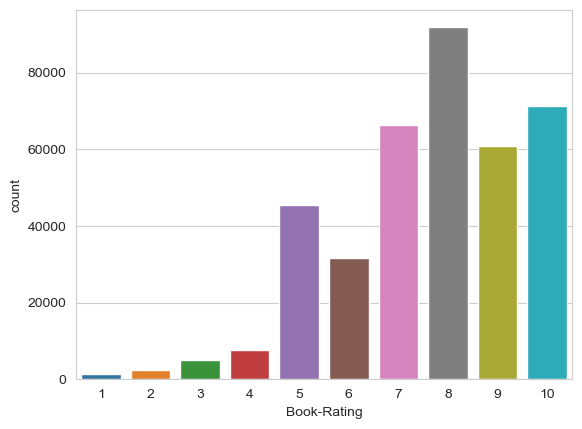

In [18]:
_ = sns.countplot(x=data['Book-Rating'].sort_values(), data=data)

* The graph looks more accurate now.

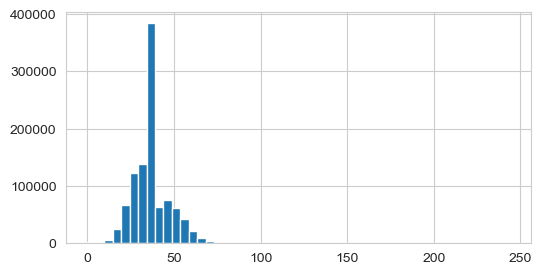

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(data.Age,bins=50)
plt.show()

From the graph we can see that the age goes beyond a hundred years and reaches 250 or on the contrary, the age can be close to zero years old, which is an error in completing the data, so I decided to change the age what is higer than 100 and the age what is smaller than 10 to the median value of age.

In [20]:
median_age = np.median(data['Age'])
data['Age'] = np.where((data['Age'] < 10) | (data['Age'] > 100), median_age, data['Age'])

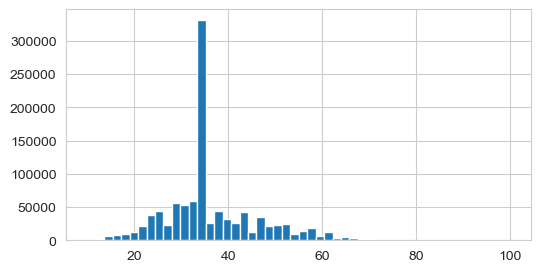

In [21]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(data.Age,bins=50)
plt.show()

* Now we can see that most of the reviews are done by people between 30 and 40 years old.

In [22]:
# Finally, I will replace all missing values with the median rating of the book
median_rating = data['Book-Rating'].median()
data['Book-Rating'].fillna(median_rating, inplace=True)

### Univariate descriptive statistics
* I'll describe the **Age** feature from the dataset using univariate descriptive statistics.

,Title,Value
0,Minimal value,10.0
1,Maximal value,100.0
2,Range,90.0
3,Average,36.58
4,Median,35.0
5,Variance,105.2


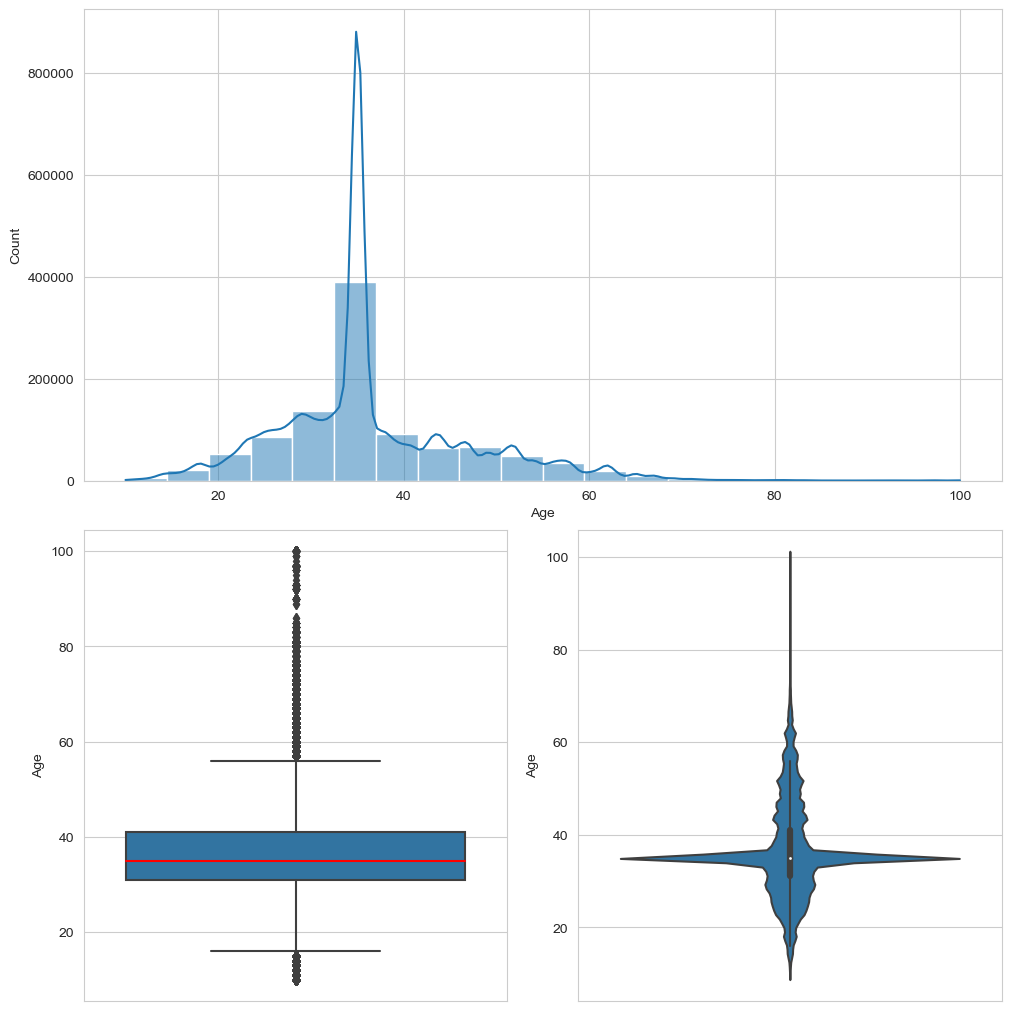

In [23]:
# Univariate descriptive statistics for continuous data
def univariate_cont(df, column):
    stats_df = pd.DataFrame(np.array([
        ['Minimal value', df[column].min()],
        ['Maximal value', df[column].max()],
        ['Range', df[column].max() - df[column].min()],
        ['Average', round(df[column].mean(), 2)],
        ['Median', df[column].median()],
        ['Variance', round(df[column].var(), 2)]
    ]), columns=['Title', 'Value'])

    display(stats_df)

    # Initializing the image layout
    fig = plt.figure(figsize=(10,10), constrained_layout=True)
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax1 = fig.add_subplot(spec[0, :])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])
    sns.histplot(data=df, bins = 20, x=column, kde=True, ax=ax1)

    # x and y - graf rotation
    sns.boxplot(data=df, y=column, ax=ax2, medianprops={'color': 'red'})
    sns.violinplot(data=df, y=column, ax=ax3)

univariate_cont(data, 'Age')

* First graph **(histogram)** shows the distribution of user ages. The values of ages are distributed from minimum to maximum values, in this case from 10 to 100. On this graph we can also see the shape of the distribution - it is close to a normal (Gaussian) distribution with a peak around 30-40 years old.
* The second graph **(boxplot)** shows descriptive statistics for user ages. The center of the graph shows the median age (the value that divides the data set into two equal parts). The upper boundary (upper boxplot boundary) is the 75th percentile, and the lower boundary (lower boxplot boundary) is the 25th percentile. "The whiskers" show the interquartile range, which is the difference between the 75th and 25th percentiles. The outliers are indicated by circles on the graph.
* The third graph **(violinplot)** shows an estimate of the density distribution of user ages. It shows the probability distribution, which can be used to compare the distribution of ages in different subgroups of users.

### Collaborative Filtering

In [24]:
# Load dataset in Surprise format
reader = Reader(rating_scale=(1, 10))
data_Surprise = Dataset.load_from_df(data[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [25]:
# Set the hyperparameter grid to find the best model
param_grid = {'n_factors': [50, 100], 
              'n_epochs': [20, 30], 
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

In [26]:
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_search.fit(data_Surprise)

In [27]:
print('Best RMSE score: {:.3f}'.format(grid_search.best_score['rmse']))
print('Best MAE score: {:.3f}'.format(grid_search.best_score['mae']))

Best RMSE score: 1.070
Best MAE score: 0.602


In [28]:
print('Best hyperparameters:', grid_search.best_params)

Best hyperparameters: {'rmse': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.6}}


> **RMSE** is more sensitive to outliers because it sums the squares of the outliers, which can lead to overestimation of errors if there are outliers. RMSE is also more sensitive to larger error values, since the square of the error is factored into the calculation.

> **MAE** does not account for the interaction of error squares, which makes it more robust to outliers and large error values. MAE is also easier to interpret because it gives an absolute value of the outlier that is easy to understand.

The main goal of the project is to minimize prediction error, then both metrics can be used to estimate the model. However, accuracy of prediction values is the most important goal, so it is better to use **RMSE**, since it penalizes large errors more severely than **MAE**.

In [29]:
data.tail()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
1031131,276442,250830,7.0,104678,53941,99,8488,7345,62.0
1031132,276618,261404,5.0,113038,60976,81,2481,19309,35.0
1031133,276647,121170,8.0,35210,56442,98,14080,837,13.0
1031134,276647,151352,10.0,81799,4156,95,13665,837,13.0
1031135,276660,123627,8.0,146158,19737,82,6624,18283,15.0


I'll choose an **User-ID** from the dataset for which I will then find the top 10 recommendations.

In [30]:
best_params = grid_search.best_params
svd = SVD(n_factors=best_params['rmse']['n_factors'], n_epochs=best_params['rmse']['n_epochs'], 
                                lr_all=best_params['rmse']['lr_all'], reg_all=best_params['rmse']['reg_all'])

trainset, testset = train_test_split(data_Surprise, test_size=0.25)
svd.fit(trainset)
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
print('RMSE on the test set: {:.3f}'.format(rmse))

RMSE: 1.0696
RMSE on the test set: 1.070


In [31]:
# Get the top 10 recommendations for the user with id = 276618
user_id = '276618'
books_already_rated_by_user = [item[0] for item in trainset.ur[int(user_id)]]
unseen_books_by_user = list(set(data_Surprise.df['ISBN'].unique()) - set(books_already_rated_by_user))

unseen_books_by_user_predictions = [[user_id, book_id, 0] for book_id in unseen_books_by_user]
predictions_unseen = svd.test(unseen_books_by_user_predictions)
top_n = sorted(predictions_unseen, key=lambda x: x.est, reverse=True)[:10]

In [32]:
# Create a list of dictionaries containing the top recommendations
top_n_list = [{'Index': i+1, 'Book-ID': predictions_unseen.iid, 'Rating': round(predictions_unseen.est, 2)} 
              for i, predictions_unseen in enumerate(top_n)]

# Convert the list of dictionaries to a Pandas DataFrame
top_n_df = pd.DataFrame(top_n_list)

# Set the index to be the Rank column
top_n_df.set_index('Index', inplace=True)

print(top_n_df)

       Book-ID  Rating
Index                 
1        74802    8.74
2        74701    8.69
3       189253    8.66
4       189366    8.65
5         5084    8.64
6        13456    8.62
7       209430    8.62
8         5082    8.62
9       258378    8.60
10      259294    8.59


The implemented model is an example of a user-based collaborative filtering, since it recommends items based on the past behavior of similar users.